In [1]:
# ============================================
# (1) Import Library
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib


In [2]:
# ============================================
# (2) Load Dataset
# ============================================
df = pd.read_csv("DailyDelhiClimate.csv", parse_dates=['date'], index_col='date')
print("Data awal:")
print(df.head())

Data awal:
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000


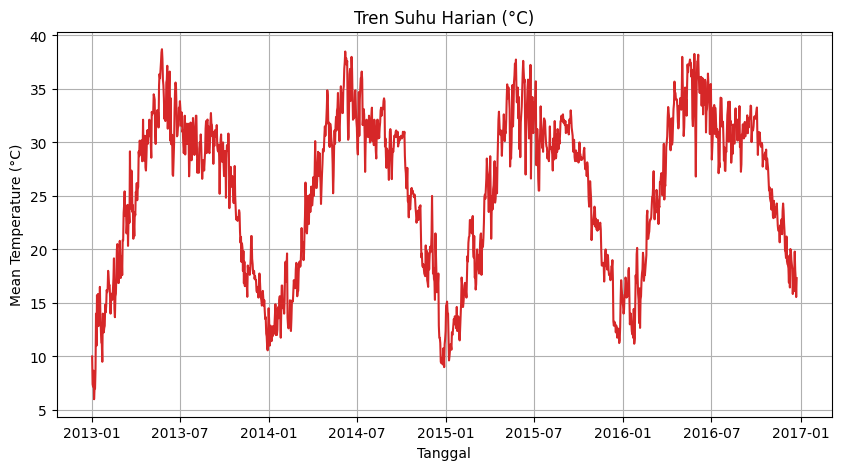

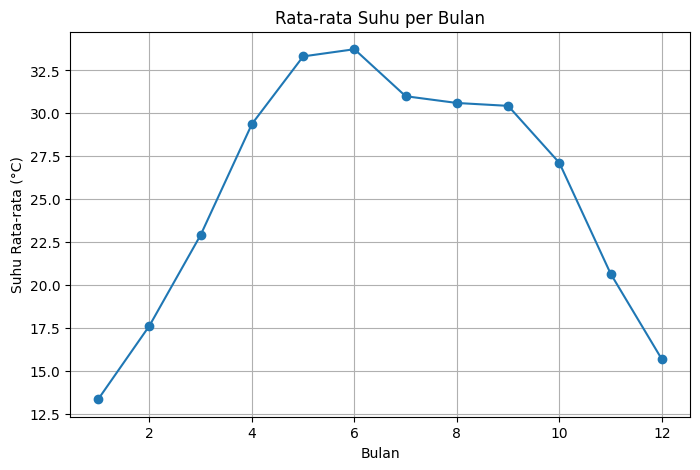

=== Analisis Musiman ===
month
1     13.34
2     17.62
3     22.91
4     29.38
5     33.32
6     33.73
7     31.00
8     30.60
9     30.43
10    27.11
11    20.66
12    15.67
Name: meantemp, dtype: float64
Suhu tertinggi: 33.73°C (Bulan 6)
Suhu terendah: 13.34°C (Bulan 1)


In [3]:
# ============================================
# (3) Eksplorasi Data (EDA)
# ============================================

# ---- 3.1 Tren Suhu ----
plt.figure(figsize=(10,5))
plt.plot(df.index, df['meantemp'], color='tab:red')
plt.title('Tren Suhu Harian (°C)')
plt.xlabel('Tanggal')
plt.ylabel('Mean Temperature (°C)')
plt.grid(True)
plt.show()

# ---- 3.2 Analisis Musiman (Seasonality) ----
df['month'] = df.index.month
monthly_avg = df.groupby('month')['meantemp'].mean()

plt.figure(figsize=(8,5))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', color='tab:blue')
plt.title('Rata-rata Suhu per Bulan')
plt.xlabel('Bulan')
plt.ylabel('Suhu Rata-rata (°C)')
plt.grid(True)
plt.show()

print("=== Analisis Musiman ===")
print(monthly_avg.round(2))
print(f"Suhu tertinggi: {monthly_avg.max():.2f}°C (Bulan {monthly_avg.idxmax()})")
print(f"Suhu terendah: {monthly_avg.min():.2f}°C (Bulan {monthly_avg.idxmin()})")


In [4]:
# ============================================
# (4) Pra-pemrosesan Data
# ============================================

# Pilih hanya kolom yang digunakan
data = df[['meantemp']].values

# Normalisasi (Scaling)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
joblib.dump(scaler, "temperature_scaler.save")
print("\nSkala data selesai dinormalisasi (0–1).")

# ---- Membuat Sekuens (Windowing) ----
def create_sequences(dataset, timestep=30):
    X, y = [], []
    for i in range(len(dataset) - timestep):
        X.append(dataset[i:i+timestep])
        y.append(dataset[i+timestep])
    return np.array(X), np.array(y)

timestep = 30
X, y = create_sequences(scaled_data, timestep)
print(f"\nBentuk data setelah windowing: X={X.shape}, y={y.shape}")

# ---- Split Data (Train, Validation, Test) ----
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Data train: {X_train.shape}, validasi: {X_val.shape}, test: {X_test.shape}")



Skala data selesai dinormalisasi (0–1).

Bentuk data setelah windowing: X=(1424, 30, 1), y=(1424, 1)
Data train: (1139, 30, 1), validasi: (142, 30, 1), test: (143, 30, 1)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 3190

c:\Users\intan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 - 1s - loss: 0.0108 - val_loss: 0.0060 - 1s/epoch - 38ms/step
Epoch 3/25
36/36 - 2s - loss: 0.0083 - val_loss: 0.0056 - 2s/epoch - 44ms/step
Epoch 4/25
36/36 - 1s - loss: 0.0083 - val_loss: 0.0063 - 1s/epoch - 39ms/step
Epoch 5/25
36/36 - 1s - loss: 0.0079 - val_loss: 0.0056 - 1s/epoch - 40ms/step
Epoch 6/25
36/36 - 2s - loss: 0.0080 - val_loss: 0.0058 - 2s/epoch - 54ms/step
Epoch 7/25
36/36 - 2s - loss: 0.0073 - val_loss: 0.0052 - 2s/epoch - 53ms/step
Epoch 8/25
36/36 - 1s - loss: 0.0071 - val_loss: 0.0055 - 1s/epoch - 40ms/step
Epoch 9/25
36/36 - 2s - loss: 0.0068 - val_loss: 0.0052 - 2s/epoch - 49ms/step
Epoch 10/25
36/36 - 2s - loss: 0.0066 - val_loss: 0.0061 - 2s/epoch - 50ms/step
Epoch 11/25
36/36 - 1s - loss: 0.0067 - val_loss: 0.0069 - 1s/epoch - 35ms/step
Epoch 12/25
36/36 - 1s - loss: 0.0064 - val_loss: 0.0054 - 1s/epoch - 35ms/step
Epoch 13/25
36/36 - 1s - loss: 0.0066 - val_loss: 0.0055 - 1s/epoch - 38ms/step
Epoch 14/25
36/36 - 1s - loss: 0.0063 - val_loss: 0.0053 - 

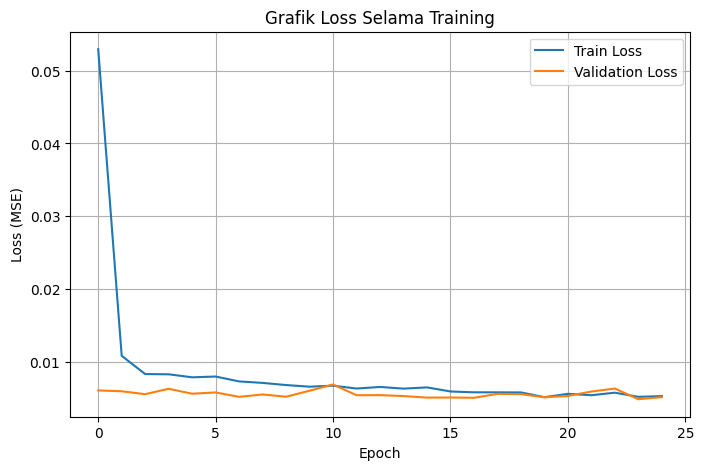

In [5]:
# ============================================
# (5) Bangun dan Latih Model LSTM
# ============================================
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# ---- Callback ----
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
mc = ModelCheckpoint("lstm_meantemp_model.h5", monitor='val_loss', save_best_only=True)

# ---- Training ----
history = model.fit(
    X_train, y_train,
    epochs=25,          # Sesuai instruksi (25 epoch)
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es, mc],
    verbose=2
)

# ---- Plot Loss ----
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Grafik Loss Selama Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


5/5 [==============================] - 1s 14ms/step

=== HASIL EVALUASI MODEL ===
Mean Squared Error (MSE): 2.2063
Root Mean Squared Error (RMSE): 1.4854°C
Mean Absolute Error (MAE): 1.1757°C
R-squared (R²): 0.9185
Mean Absolute Percentage Error (MAPE): 4.68%


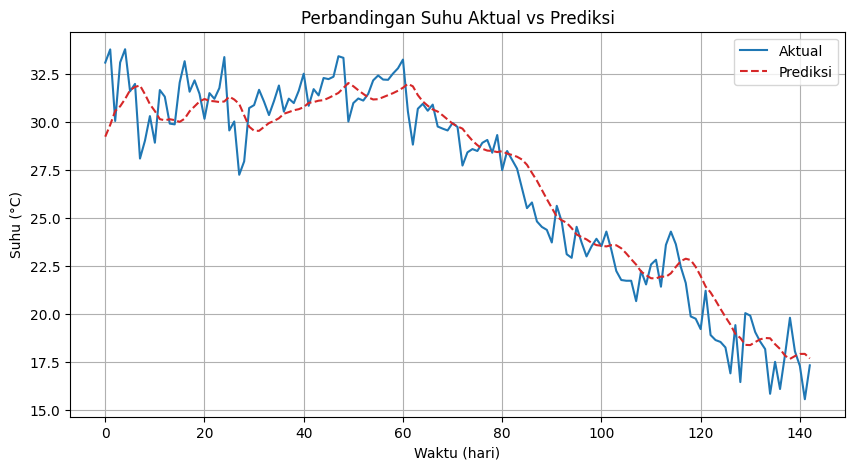


✅ Model menunjukkan performa yang baik jika RMSE < 3°C dan R² > 0.8.


In [6]:
# ============================================
# (6) Evaluasi Kinerja Model
# ============================================

# Prediksi pada data test
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test)

# Hitung metrik evaluasi
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

print("\n=== HASIL EVALUASI MODEL ===")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}°C")
print(f"Mean Absolute Error (MAE): {mae:.4f}°C")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# ---- Visualisasi Prediksi vs Aktual ----
plt.figure(figsize=(10,5))
plt.plot(y_actual, label='Aktual', color='tab:blue')
plt.plot(y_pred, label='Prediksi', color='tab:red', linestyle='--')
plt.title('Perbandingan Suhu Aktual vs Prediksi')
plt.xlabel('Waktu (hari)')
plt.ylabel('Suhu (°C)')
plt.legend()
plt.grid(True)
plt.show()

print("\n✅ Model menunjukkan performa yang baik jika RMSE < 3°C dan R² > 0.8.")


In [7]:
# ============================================
# (7) Simpan Model & Scaler
# ============================================
model.save("model_prediksi_suhu.h5")
print("\nModel dan scaler berhasil disimpan!")



Model dan scaler berhasil disimpan!


c:\Users\intan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
